In [1]:
!pip install pandas numpy scikit-learn xgboost catboost shap tensorflow ctgan

In [2]:
import pandas as pd
import numpy as np
import shap
import warnings
import os
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Preprocessing & Metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Data Augmentation
try:
    from ctgan import CTGAN, TVAE
except ImportError:
    raise ImportError("Please install ctgan: pip install ctgan")

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Setup Complete. All Libraries Imported.")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Setup Complete. All Libraries Imported.


In [3]:
# === PHASE 1: LOAD DATASET ===

print("[Phase 1] Loading Data...", flush=True)
df = pd.read_csv('AmesHousing.csv')
print("    Loaded from local runtime.")

[Phase 1] Loading Data...
    Loaded from local runtime.


[Phase 2] Running Comprehensive EDA...

--- 1.1 Dataset Structure ---
Shape: (2930, 82)

--- 1.2 Column Types ---
object     43
int64      28
float64    11
Name: count, dtype: int64

--- 1.3 Missing Value Analysis ---
Columns with missing values: 27
                Missing Count Percent
Pool QC                  2917  99.56%
Misc Feature             2824  96.38%
Alley                    2732  93.24%
Fence                    2358  80.48%
Mas Vnr Type             1775  60.58%
Fireplace Qu             1422  48.53%
Lot Frontage              490  16.72%
Garage Qual               159   5.43%
Garage Cond               159   5.43%
Garage Yr Blt             159   5.43%
Garage Finish             159   5.43%
Garage Type               157   5.36%
Bsmt Exposure              83   2.83%
BsmtFin Type 2             81   2.76%
Bsmt Cond                  80   2.73%

--- 1.4 Duplicate Check ---
Duplicate Rows: 0

2. TARGET DISTRIBUTION ANALYSIS


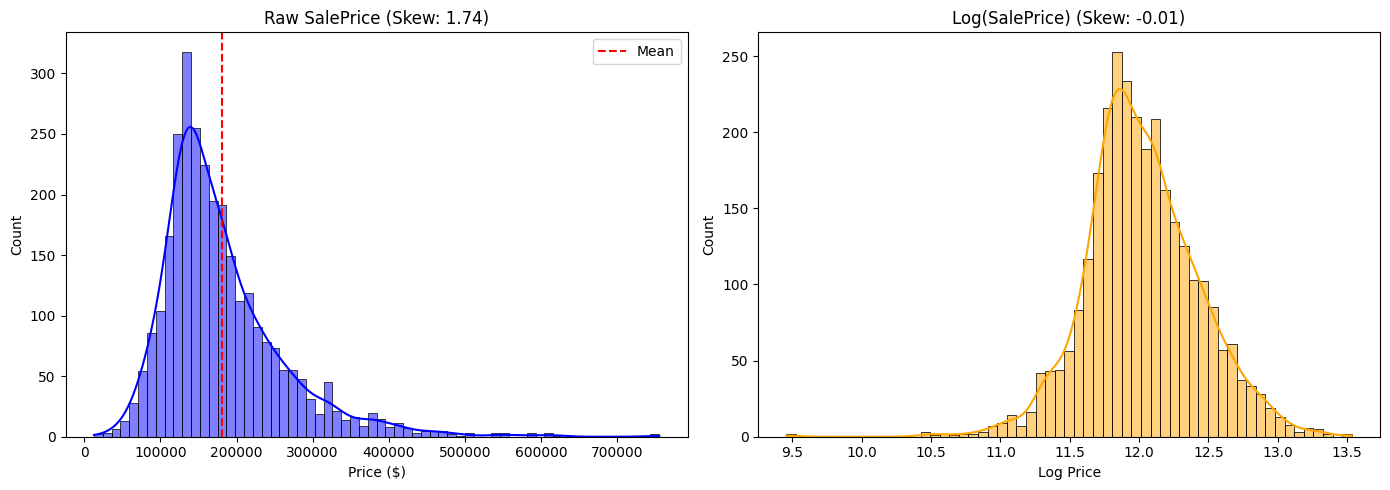


3. NUMERIC CORRELATIONS
Top 10 Features Correlated with SalePrice:
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Garage Yr Blt     0.526965
Name: SalePrice, dtype: float64


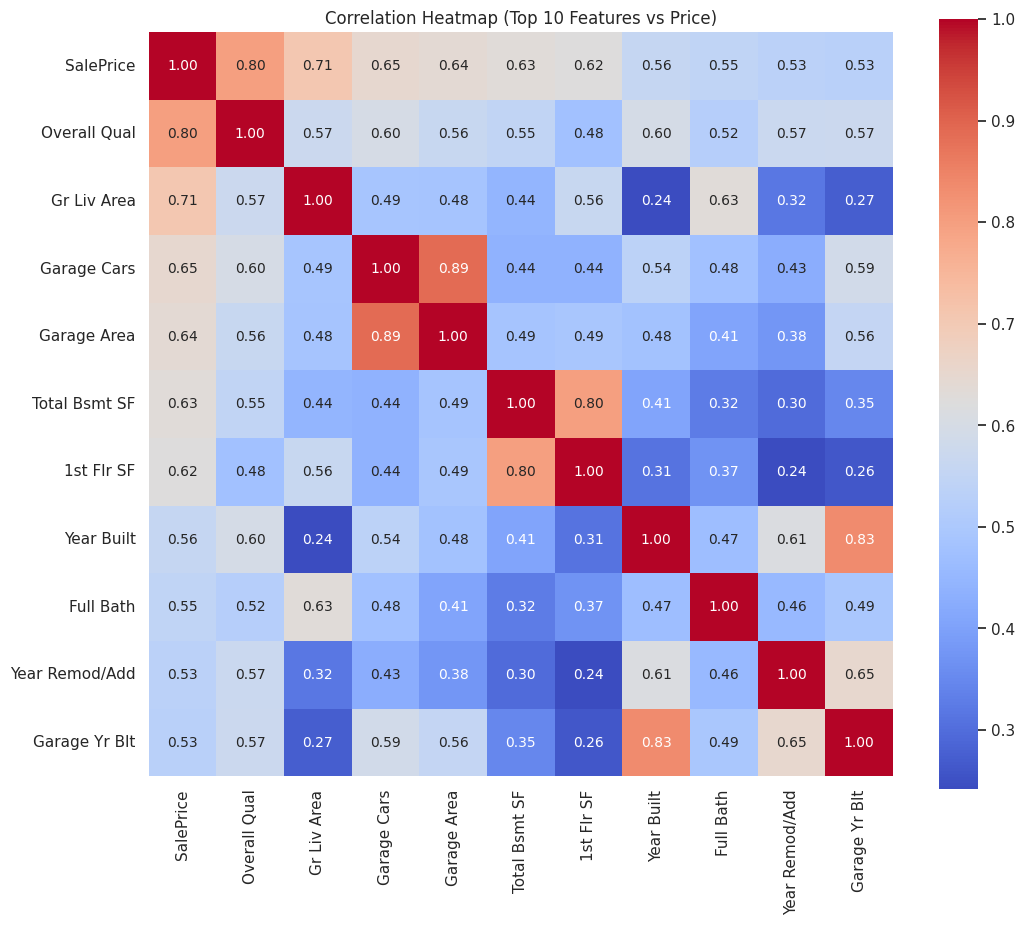


--- 4. Outlier Detection ---


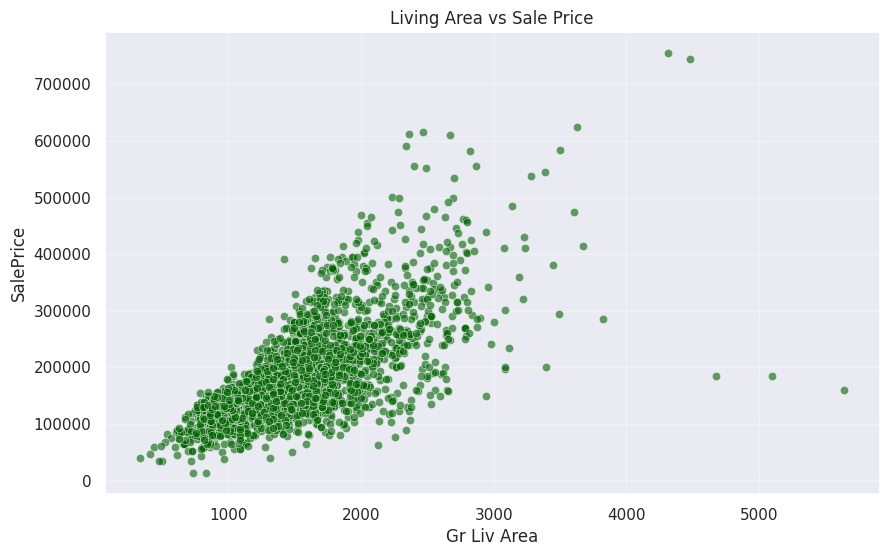


--- 5. ANOVA Analysis ---
Top 5 Categorical Features (F-Score):
Exter Qual           F-Score: 993.96
Bsmt Qual            F-Score: 724.16
Kitchen Qual         F-Score: 680.47
Garage Finish        F-Score: 520.89
Foundation           F-Score: 227.57


In [4]:
# === PHASE 2: COMPLETE EXPLORATORY DATA ANALYSIS (EDA) ===
print("[Phase 2] Running Comprehensive EDA...", flush=True)

# 1. Dataset Information
def print_detailed_info(df):
    print("\n--- 1.1 Dataset Structure ---")
    print(f"Shape: {df.shape}")

    print("\n--- 1.2 Column Types ---")
    print(df.dtypes.value_counts())

    print("\n--- 1.3 Missing Value Analysis ---")
    null_counts = df.isnull().sum()
    null_pct = (df.isnull().sum() / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': null_counts,
        'Percent': null_pct
    })
    missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

    # Format percentages for display
    missing_data['Percent'] = missing_data['Percent'].map('{:.2f}%'.format)

    if not missing_data.empty:
        print(f"Columns with missing values: {len(missing_data)}")
        print(missing_data.head(15).to_string()) # Show top 15
    else:
        print("No missing values found.")

    print("\n--- 1.4 Duplicate Check ---")
    print(f"Duplicate Rows: {df.duplicated().sum()}")

# Run the info function
print_detailed_info(df)

# 2. Target Distribution
print("\n" + "="*40)
print("2. TARGET DISTRIBUTION ANALYSIS")
print("="*40)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw Distribution
sns.histplot(df['SalePrice'], kde=True, ax=axes[0], color='blue')
axes[0].set_title(f"Raw SalePrice (Skew: {df['SalePrice'].skew():.2f})")
axes[0].set_xlabel("Price ($)")
axes[0].axvline(df['SalePrice'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Log-Transformed Distribution
# We check this because regression models often prefer normal distributions
sns.histplot(np.log1p(df['SalePrice']), kde=True, ax=axes[1], color='orange')
axes[1].set_title(f"Log(SalePrice) (Skew: {np.log1p(df['SalePrice']).skew():.2f})")
axes[1].set_xlabel("Log Price")

plt.tight_layout()
plt.show()

# 3. Correlation Heatmap
print("\n" + "="*40)
print("3. NUMERIC CORRELATIONS")
print("="*40)

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])
# Drop ID columns if they exist as they are not useful features
numeric_df = numeric_df.drop(columns=['Order', 'PID', 'Id'], errors='ignore')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Get Top 10 Features correlated with Price
k = 11 # Number of variables for heatmap (10 features + SalePrice)
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = df[cols].corr()

print("Top 10 Features Correlated with SalePrice:")
print(corr_matrix['SalePrice'].sort_values(ascending=False).head(11).iloc[1:]) # Skip SalePrice itself

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.0)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 10}, yticklabels=cols.values,
            xticklabels=cols.values, cmap='coolwarm')
plt.title('Correlation Heatmap (Top 10 Features vs Price)')
plt.show()

# 4. Outlier Detection
print("\n--- 4. Outlier Detection ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df, alpha=0.6, color='darkgreen')
plt.title('Living Area vs Sale Price')
plt.grid(True, alpha=0.3)
plt.show()

# 5. ANOVA
print("\n--- 5. ANOVA Analysis ---")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
significant_cats = []
for col in cat_cols:
    valid_data = df.dropna(subset=[col, 'SalePrice'])
    groups = [valid_data[valid_data[col] == c]['SalePrice'].values for c in valid_data[col].unique()]
    if len(groups) > 1:
        try:
            f_stat, p_val = stats.f_oneway(*groups)
            if p_val < 0.05: significant_cats.append((col, f_stat))
        except: pass
significant_cats.sort(key=lambda x: x[1], reverse=True)
print("Top 5 Categorical Features (F-Score):")
for name, score in significant_cats[:5]: print(f"{name:<20} F-Score: {score:.2f}")

[Phase 3] Robust Preprocessing (Best Config)...
    Removed 2 outliers from training data
    Applying Domain Imputation...
    Engineering Features...
    Encoding Categoricals...
    Running SHAP Selection...
    Top 3 Features: ['Overall Qual', 'TotalSF', 'TotalBath']


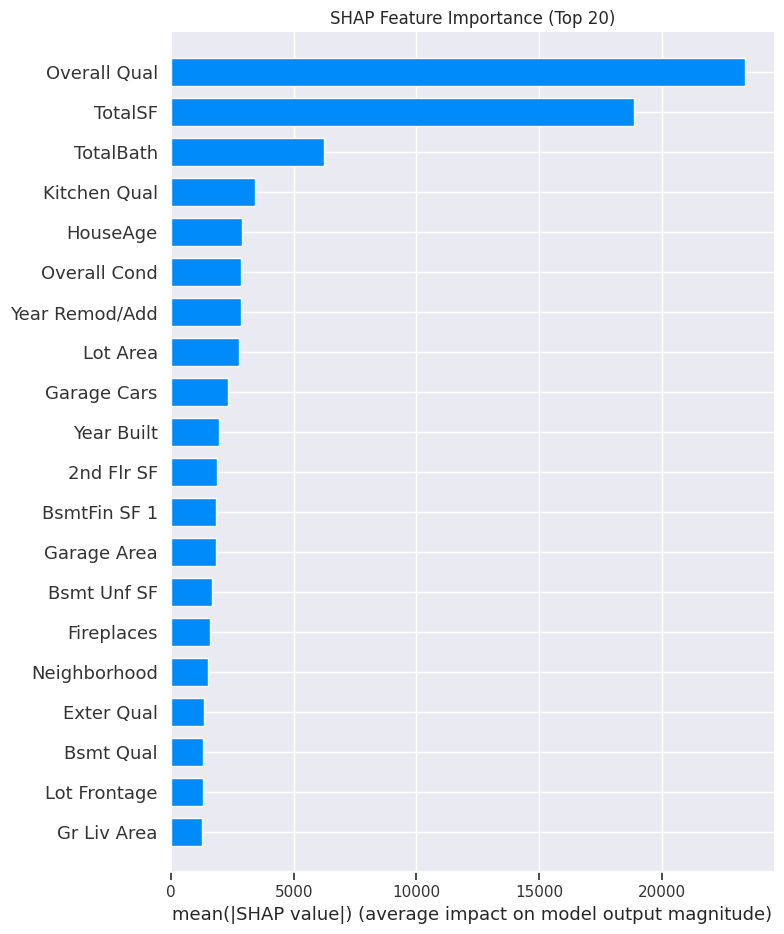

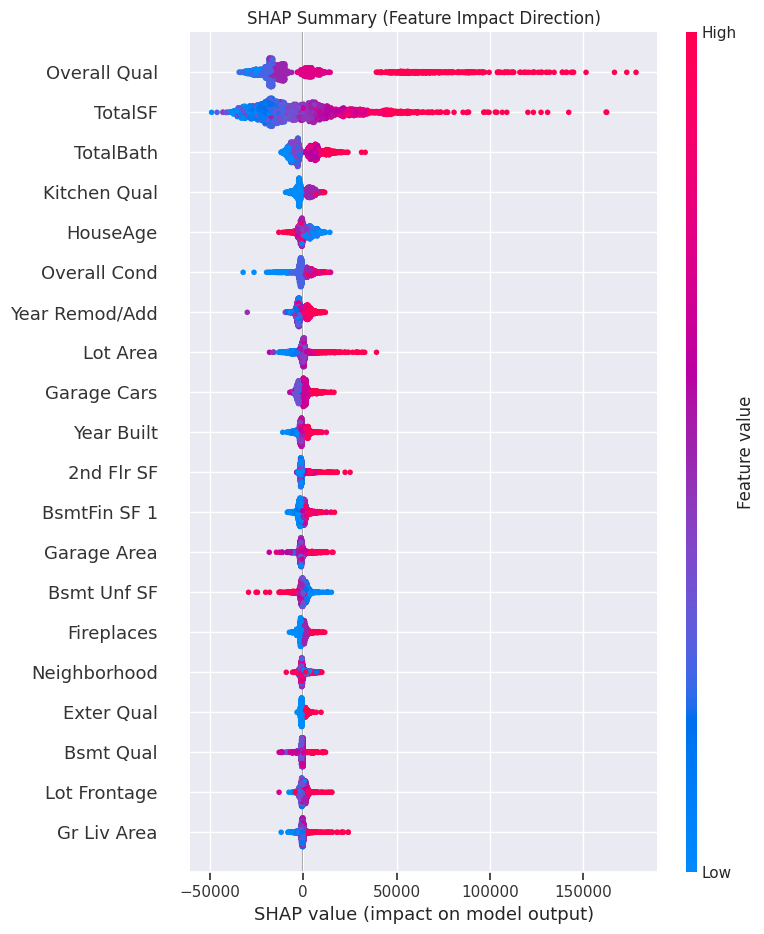

    Phase 3 Complete.


In [15]:
# === PHASE 3: PREPROCESSING ===
print("[Phase 3] Preprocessing...", flush=True)

# 1. Setup Feature and Target
X = df.drop(columns=['SalePrice', 'Order', 'PID', 'Id'], errors='ignore')
y = df['SalePrice']

# Capture original categorical columns BEFORE splitting
original_cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. SPLIT FIRST (Crucial)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

# Remove extreme outliers in Train
if 'Gr Liv Area' in X_train.columns:
    outlier_mask = (X_train['Gr Liv Area'] > 4000) & (y_train < 200000)
    X_train = X_train[~outlier_mask]
    y_train = y_train[~outlier_mask]
    print(f"    Removed {outlier_mask.sum()} outliers from training data")

# --- A. DOMAIN IMPUTATION ---
print("    Applying Domain Imputation...", flush=True)
# Lot Frontage via Neighborhood Median (Computed on Train)
if 'Lot Frontage' in X_train.columns and 'Neighborhood' in X_train.columns:
    frontage_map = X_train.groupby('Neighborhood')['Lot Frontage'].median()
    global_frontage_median = X_train['Lot Frontage'].median()

    def fill_frontage(df_in, map_ref, global_ref):
        filled = df_in['Neighborhood'].map(map_ref).fillna(global_ref)
        return df_in['Lot Frontage'].fillna(filled)

    X_train['Lot Frontage'] = fill_frontage(X_train, frontage_map, global_frontage_median)
    X_test['Lot Frontage'] = fill_frontage(X_test, frontage_map, global_frontage_median)

# Standard None/Zero fills
none_cols = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
             'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
             'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
             'BsmtFin Type 2', 'Mas Vnr Type']
zero_cols = ['Garage Area', 'Garage Cars', 'BsmtFin SF 1', 'BsmtFin SF 2',
             'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Mas Vnr Area']

for df_curr in [X_train, X_test]:
    cols_to_fill = [c for c in none_cols if c in df_curr.columns]
    df_curr[cols_to_fill] = df_curr[cols_to_fill].fillna("None")

    cols_to_fill_zero = [c for c in zero_cols if c in df_curr.columns]
    df_curr[cols_to_fill_zero] = df_curr[cols_to_fill_zero].fillna(0)

    if 'Garage Yr Blt' in df_curr.columns and 'Year Built' in df_curr.columns:
        df_curr['Garage Yr Blt'] = df_curr['Garage Yr Blt'].fillna(df_curr['Year Built'])

# --- B. GENERAL IMPUTATION ---
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

# --- C. FEATURE ENGINEERING (RESTORED ORIGINAL) ---
print("    Engineering Features...", flush=True)
def engineer_features(df_in):
    df_out = df_in.copy()
    # Safely create features only if columns exist
    if 'Total Bsmt SF' in df_out.columns and '1st Flr SF' in df_out.columns:
        df_out['TotalSF'] = df_out['Total Bsmt SF'] + df_out['1st Flr SF'] + df_out.get('2nd Flr SF', 0)

    if 'Full Bath' in df_out.columns:
        df_out['TotalBath'] = (df_out['Full Bath'] + 0.5*df_out.get('Half Bath', 0) +
                               df_out.get('Bsmt Full Bath', 0) + 0.5*df_out.get('Bsmt Half Bath', 0))

    if 'Yr Sold' in df_out.columns and 'Year Built' in df_out.columns:
        df_out['HouseAge'] = df_out['Yr Sold'] - df_out['Year Built']

    if 'Pool Area' in df_out.columns:
        df_out['HasPool'] = df_out['Pool Area'].apply(lambda x: 1 if x > 0 else 0)

    return df_out

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)

# --- D. ORDINAL & CATEGORICAL ENCODING ---
print("    Encoding Categoricals...", flush=True)
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
ordinal_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
                'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
                'Garage Qual', 'Garage Cond', 'Pool QC']

for col in ordinal_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(qual_map).fillna(0)
        X_test[col] = X_test[col].map(qual_map).fillna(0)

# Ordinal Encode remaining categoricals
remaining_cats = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[remaining_cats] = ord_enc.fit_transform(X_train[remaining_cats])
X_test[remaining_cats] = ord_enc.transform(X_test[remaining_cats])

# --- E. SHAP FEATURE SELECTION ---
print("    Running SHAP Selection...", flush=True)
model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
if isinstance(shap_values, list): shap_values = shap_values[0]

mean_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'feature': X_train.columns, 'shap': mean_shap}).sort_values(by='shap', ascending=False)

# Select Top 35
selected_features = shap_df.head(35)['feature'].tolist()
print(f"    Top 3 Features: {selected_features[:3]}")

# ----------------------------------------------
# SAVE DATASETS FOR SCENARIOS
# ----------------------------------------------
# 1. Skenario 1 Dataset (All Features from Preprocessing)
X_train_sk1 = X_train.copy()
X_test_sk1  = X_test.copy()

# 2. Skenario 2 Dataset (SHAP Selected)
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)
plt.title("SHAP Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

# Beeswarm plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train, max_display=20, show=False)
plt.title("SHAP Summary (Feature Impact Direction)")
plt.tight_layout()
plt.show()

# --- F. PREPARE FOR CTGAN ---
# Combine original categoricals + ordinal columns, then find which survived selection
all_potential_discrete = sorted(list(set(original_cat_cols) | set(ordinal_cols)))
cat_cols_sel = [c for c in selected_features if c in all_potential_discrete]

print("    Phase 3 Complete.")

In [16]:
# === PHASE 4: ARCHITECTURE DEFINITION & HELPERS ===

# --- 1. Optimized High-Capacity DNN ---
def build_standalone_dnn(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.3),
        Dense(64, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.2),
        Dense(32, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

# --- 2. HouseStackNet ---
class HouseStackNet:
    def __init__(self, meta_learner_type='dnn'):
        self.meta_learner_type = meta_learner_type
        # LEVEL 0: Base Learners
        self.models = {
            'linear': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
            'ridge':  Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=10.0))]),
            'lasso':  Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.001))]),
            'elastic': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(alpha=0.05, l1_ratio=0.5, random_state=42))]),
            'rf': RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_leaf=2, random_state=42, n_jobs=-1),
            'gb': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42),
            'xgb': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, subsample=0.7, colsample_bytree=0.7, random_state=42, n_jobs=-1),
            'cat': CatBoostRegressor(iterations=600, learning_rate=0.03, depth=6, verbose=0, random_state=42)
        }
        # LEVEL 1: Meta-Learner
        if meta_learner_type == 'ridge':
            self.meta_learner = Ridge(alpha=1.0)
        else:
            self.meta_learner = self._build_dnn(len(self.models))
        self.input_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

    def _build_dnn(self, input_dim):
        """Optimized Meta-Learner DNN"""
        model = Sequential()
        model.add(Dense(16, input_dim=input_dim, kernel_regularizer=l2(1e-4)))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dropout(0.1))
        model.add(Dense(8, kernel_regularizer=l2(1e-4)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    def fit(self, X_train, y_train):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        oof_preds = np.zeros((X_train.shape[0], len(self.models)))
        for i, (name, model) in enumerate(self.models.items()):
            for train_ix, val_ix in kf.split(X_train, y_train):
                model.fit(X_train.iloc[train_ix], y_train.iloc[train_ix])
                oof_preds[val_ix, i] = model.predict(X_train.iloc[val_ix])

        oof_scaled = self.input_scaler.fit_transform(oof_preds)
        if self.meta_learner_type == 'ridge':
            self.meta_learner.fit(oof_scaled, y_train)
        else:
            y_reshaped = y_train.values.reshape(-1, 1)
            y_scaled = self.target_scaler.fit_transform(y_reshaped)
            es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
            self.meta_learner.fit(oof_scaled, y_scaled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)

        for model in self.models.values():
            model.fit(X_train, y_train)

    def predict(self, X_test):
        base_preds = np.zeros((X_test.shape[0], len(self.models)))
        for i, (model) in enumerate(self.models.values()):
            base_preds[:, i] = model.predict(X_test)
        base_scaled = self.input_scaler.transform(base_preds)
        pred = self.meta_learner.predict(base_scaled)
        if self.meta_learner_type == 'ridge': return pred.flatten()
        return self.target_scaler.inverse_transform(pred).flatten()

def evaluate_models(X_tr, y_tr, X_te, y_te, scenario_name, use_stacking=False):
    print(f"\n>>> Running {scenario_name}...", flush=True)
    results = []

    # 1. Base Models (ALL 8 MODELS)
    models = {
        'LinearReg': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
        'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=10.0))]),
        'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.001))]),
        'ElasticNet': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(alpha=0.05))]),

        'RandomForest': RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=42),
        'GradientBoost': GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=600, learning_rate=0.03, depth=6, verbose=0, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        results.append({
            'Scenario': scenario_name, 'Model': name,
            'RMSE': np.sqrt(mean_squared_error(y_te, preds)),
            'MAE': mean_absolute_error(y_te, preds),
            'MAPE': mean_absolute_percentage_error(y_te, preds),
            'R2': r2_score(y_te, preds)
        })

    # 2. HouseStackNet
    if use_stacking:
        print(f"    Training HouseStackNet (DNN)...", flush=True)
        stack = HouseStackNet(meta_learner_type='dnn')
        stack.fit(X_tr, y_tr)
        preds = stack.predict(X_te)
        results.append({
            'Scenario': scenario_name, 'Model': 'HouseStackNet',
            'RMSE': np.sqrt(mean_squared_error(y_te, preds)),
            'MAE': mean_absolute_error(y_te, preds),
            'MAPE': mean_absolute_percentage_error(y_te, preds),
            'R2': r2_score(y_te, preds)
        })

    return pd.DataFrame(results)

# Skenario 1 (BASELINE)

In [17]:
# === PHASE 5: SKENARIO 1 (BASELINE) ===
print("\n" + "="*50)
print("SKENARIO 1: BASELINE (FULL FEATURES)")
print("="*50)
results_sk1 = evaluate_models(X_train_sk1, y_train, X_test_sk1, y_test, "Skenario 1")
print(results_sk1[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']].sort_values(by='RMSE'))


SKENARIO 1: BASELINE (FULL FEATURES)

>>> Running Skenario 1...
           Model          RMSE           MAE      MAPE        R2
7       CatBoost  26107.553268  13871.724694  0.076645  0.914986
4   RandomForest  27710.763908  15333.024817  0.084334  0.904224
6        XGBoost  27836.488284  14120.343750  0.077566  0.903353
5  GradientBoost  29302.047974  14541.284323  0.079728  0.892909
3     ElasticNet  33202.941477  19820.716180  0.112235  0.862497
1          Ridge  33324.423063  19938.098113  0.113401  0.861489
2          Lasso  33351.808961  19961.898475  0.113649  0.861261
0      LinearReg  33351.809153  19961.899667  0.113649  0.861261


# Skenario 2 (SHAP Feature Selection)

In [18]:
# === PHASE 6: SKENARIO 2 (FEATURE SELECTION) ===
print("\n" + "="*50)
print("SKENARIO 2: SHAP FEATURE SELECTION")
print("="*50)
results_sk2 = evaluate_models(X_train_sel, y_train, X_test_sel, y_test, "Skenario 2")
print(results_sk2[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']].sort_values(by='RMSE'))


SKENARIO 2: SHAP FEATURE SELECTION

>>> Running Skenario 2...
           Model          RMSE           MAE      MAPE        R2
7       CatBoost  26054.365341  13823.229270  0.076153  0.915332
4   RandomForest  27755.590137  15288.098557  0.084343  0.903914
6        XGBoost  28485.242214  14484.993164  0.079649  0.898796
5  GradientBoost  29910.612160  14773.078085  0.081635  0.888414
3     ElasticNet  34439.688660  20629.553507  0.115799  0.852063
1          Ridge  34470.036569  20704.553405  0.116674  0.851802
2          Lasso  34524.355458  20760.141864  0.117182  0.851335
0      LinearReg  34537.509997  20774.159728  0.117262  0.851221


# Skenario 3 (HouseStackNet)

In [19]:
# === PHASE 7: SKENARIO 3 (ADVANCED: STACKING + AUGMENTATION COMPARISON) ===
print("\n" + "="*60)
print("SKENARIO 3: ADVANCED MODELING (ORIGINAL VS AUGMENTED)")
print("="*60)

# ---------------------------------------------------------
# PART A: Evaluate Stacking on ORIGINAL Data (Selected Features)
# ---------------------------------------------------------
print(">>> [Part A] Baseline for Scenario 3: Original Data (Selected Features)...", flush=True)
results_sk3_orig = evaluate_models(
    X_train_sel, y_train, X_test_sel, y_test,
    "Skenario 3 (Original)",
    use_stacking=True
)

# ---------------------------------------------------------
# PART B: Data Augmentation (TVAE)
# ---------------------------------------------------------
print("\n>>> [Part B] Generating Synthetic Data (TVAE)...", flush=True)

# 1. Prepare Data
train_data_gen = pd.concat([X_train_sel.reset_index(drop=True), y_train.reset_index(drop=True).rename("SalePrice")], axis=1)

# 2. Train TVAE
tvae = TVAE(epochs=50, batch_size=500, verbose=True)
tvae.fit(train_data_gen, discrete_columns=cat_cols_sel)

# 3. Generate
NUM_ADD = 2070
syn_data = tvae.sample(NUM_ADD)

# 4. Combine
X_syn = syn_data.drop('SalePrice', axis=1)
y_syn = syn_data['SalePrice']
X_aug = pd.concat([X_train_sel, X_syn], axis=0).reset_index(drop=True)
y_aug = pd.concat([y_train, y_syn], axis=0).reset_index(drop=True)

print(f"    Augmentation Complete. Added {len(X_syn)} rows.")

# ---------------------------------------------------------
# PART C: Evaluate Stacking on AUGMENTED Data
# ---------------------------------------------------------
print("\n>>> [Part C] Evaluation on Augmented Data...", flush=True)
results_sk3_aug = evaluate_models(
    X_aug, y_aug, X_test_sel, y_test,
    "Skenario 3 (Augmented)",
    use_stacking=True
)

# Combine Scenario 3 Results for internal display
results_sk3_total = pd.concat([results_sk3_orig, results_sk3_aug], ignore_index=True)
print("\n--- Scenario 3 Internal Comparison ---")
print(results_sk3_total[['Scenario', 'Model', 'RMSE', 'R2']].sort_values(by='RMSE'))


SKENARIO 3: ADVANCED MODELING (ORIGINAL VS AUGMENTED)
>>> [Part A] Baseline for Scenario 3: Original Data (Selected Features)...

>>> Running Skenario 3 (Original)...
    Training HouseStackNet (DNN)...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

>>> [Part B] Generating Synthetic Data (TVAE)...


Loss: 18.530: 100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


    Augmentation Complete. Added 2070 rows.

>>> [Part C] Evaluation on Augmented Data...

>>> Running Skenario 3 (Augmented)...
    Training HouseStackNet (DNN)...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Scenario 3 Internal Comparison ---
                  Scenario          Model          RMSE        R2
7    Skenario 3 (Original)       CatBoost  26054.365341  0.915332
8    Skenario 3 (Original)  HouseStackNet  26945.546274  0.909441
16  Skenario 3 (Augmented)       CatBoost  27185.881478  0.907818
4    Skenario 3 (Original)   RandomForest  27755.590137  0.903914
13  Skenario 3 (Augmented)   RandomForest  28152.464669  0.901147
6    Skenario 3 (Original)        XGBoost  28485.242214  0.898796
5    Skenario 3 (Original)  GradientBoost  29910.612160  0.888414
14  Skenario 3 (Augmented)  GradientBoost  30418.155823  0.884595
17  Skenario 3 (Augmented)  HouseStackNet  30880.293263  0.881062
15  Skenario 3 (Augmented)        XGBoost  31382.679554  0.877160
3    Skenario 3 (Original)   


FINAL RESULTS COMPARISON (ALL SCENARIOS)

📊 DETAILED ANALYSIS: RMSE
--------------------------------------------------------------------------------
Scenario       Skenario 1  Skenario 2  Skenario 3 (Augmented)  \
Model                                                           
CatBoost       26107.5533  26054.3653              27185.8815   
ElasticNet     33202.9415  34439.6887              35659.9816   
GradientBoost  29302.0480  29910.6122              30418.1558   
HouseStackNet         NaN         NaN              30880.2933   
Lasso          33351.8090  34524.3555              35627.2871   
LinearReg      33351.8092  34537.5100              35627.2867   
RandomForest   27710.7639  27755.5901              28152.4647   
Ridge          33324.4231  34470.0366              35629.7207   
XGBoost        27836.4883  28485.2422              31382.6796   

Scenario       Skenario 3 (Original)  Effect: Feature Selection  \
Model                                                             


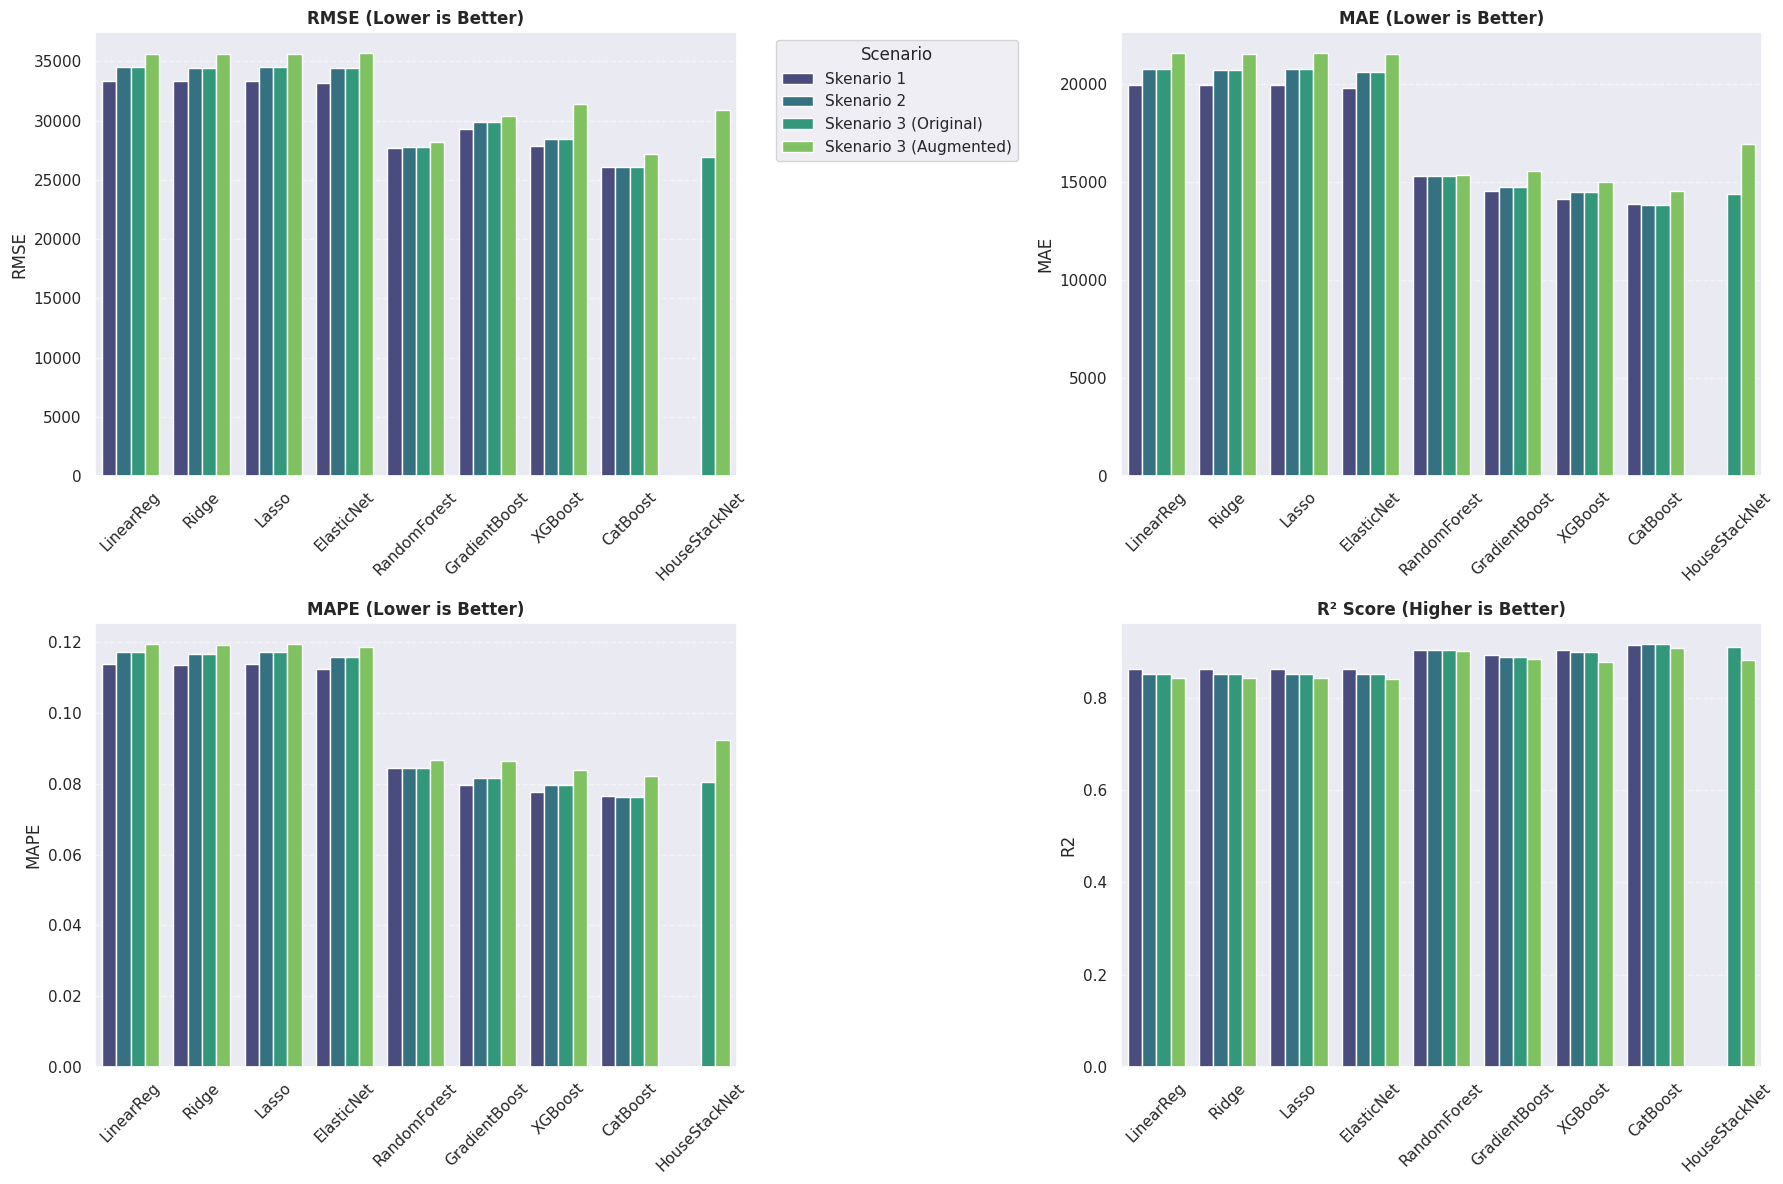

In [20]:
# === PHASE 8: FINAL COMPARISON (ALL METRICS) ===
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON (ALL SCENARIOS)")
print("="*80)

# Combine all results from all scenarios
final_df = pd.concat([results_sk1, results_sk2, results_sk3_orig, results_sk3_aug], ignore_index=True)

# List of metrics to analyze
metrics = ['RMSE', 'MAE', 'MAPE', 'R2']

# 1. Print Pivot Tables for each Metric
for metric in metrics:
    print(f"\n📊 DETAILED ANALYSIS: {metric}")
    print("-" * 80)

    # Create Pivot: Rows=Model, Cols=Scenario
    pivot = final_df.pivot(index='Model', columns='Scenario', values=metric)

    # Calculate Specific Impacts
    # Impact 1: Selection (Skenario 2 vs 1)
    pivot['Effect: Feature Selection'] = pivot['Skenario 2'] - pivot['Skenario 1']

    # Impact 2: Augmentation (Skenario 3 Aug vs Skenario 3 Orig)
    # This is the cleanest comparison because the model architecture is identical
    pivot['Effect: Augmentation'] = pivot['Skenario 3 (Augmented)'] - pivot['Skenario 3 (Original)']

    print(pivot.round(4))

# 2. Visualization Dashboard (4 Subplots)
print("\n" + "="*80)
print("VISUALIZATION DASHBOARD")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

titles = {
    'RMSE': 'RMSE (Lower is Better)',
    'MAE':  'MAE (Lower is Better)',
    'MAPE': 'MAPE (Lower is Better)',
    'R2':   'R² Score (Higher is Better)'
}

for i, metric in enumerate(metrics):
    sns.barplot(
        data=final_df,
        x='Model',
        y=metric,
        hue='Scenario',
        palette='viridis',
        ax=axes[i]
    )

    axes[i].set_title(titles[metric], fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Handle Legend
    if i == 0:
        axes[i].legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.show()

In [21]:
# === PHASE 9: FINAL COMPARISON (ALL METRICS) ===
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON (ALL SCENARIOS)")
print("="*80)

# Combine all results from all scenarios
final_df = pd.concat([results_sk1, results_sk2, results_sk3_orig, results_sk3_aug], ignore_index=True)

# List of metrics to analyze
metrics = ['RMSE', 'MAE', 'MAPE', 'R2']

for metric in metrics:
    print(f"\n📊 DETAILED ANALYSIS: {metric}")

    # Create Pivot: Rows=Model, Cols=Scenario
    pivot = final_df.pivot(index='Model', columns='Scenario', values=metric)

    # Calculate Impacts
    pivot['Impact of SHAP'] = pivot['Skenario 2'] - pivot['Skenario 1']
    pivot['Impact of Augmentation'] = pivot['Skenario 3 (Augmented)'] - pivot['Skenario 3 (Original)']

    # Define formatting based on metric type
    if metric == 'R2':
        fmt = '{:.4f}'
        cmap = 'RdYlGn' # Red to Green (Higher is better)
    elif metric == 'MAPE':
        fmt = '{:.2%}'
        cmap = 'RdYlGn_r' # Green to Red (Lower is better)
    else:
        fmt = '{:,.0f}'
        cmap = 'RdYlGn_r' # Green to Red (Lower is better)

    # Style the Pivot Table
    styled_pivot = pivot.style\
        .format(fmt)\
        .background_gradient(cmap=cmap, subset=['Skenario 1', 'Skenario 2', 'Skenario 3 (Original)', 'Skenario 3 (Augmented)'])\
        .bar(subset=['Impact of SHAP', 'Impact of Augmentation'], align='mid', color=['#d65f5f', '#5fba7d'])

    # DISPLAY instead of Print
    display(styled_pivot)


FINAL RESULTS COMPARISON (ALL SCENARIOS)

📊 DETAILED ANALYSIS: RMSE


Scenario,Skenario 1,Skenario 2,Skenario 3 (Augmented),Skenario 3 (Original),Impact of SHAP,Impact of Augmentation
Model,,,,,,
CatBoost,"26,108","26,054","27,186","26,054",-53,"1,132"
ElasticNet,"33,203","34,440","35,660","34,440","1,237","1,220"
GradientBoost,"29,302","29,911","30,418","29,911",609,508
HouseStackNet,nan,nan,"30,880","26,946",nan,"3,935"
Lasso,"33,352","34,524","35,627","34,524","1,173","1,103"
LinearReg,"33,352","34,538","35,627","34,538","1,186","1,090"
RandomForest,"27,711","27,756","28,152","27,756",45,397
Ridge,"33,324","34,470","35,630","34,470","1,146","1,160"
XGBoost,"27,836","28,485","31,383","28,485",649,"2,897"



📊 DETAILED ANALYSIS: MAE


Scenario,Skenario 1,Skenario 2,Skenario 3 (Augmented),Skenario 3 (Original),Impact of SHAP,Impact of Augmentation
Model,,,,,,
CatBoost,"13,872","13,823","14,554","13,823",-48,731
ElasticNet,"19,821","20,630","21,531","20,630",809,901
GradientBoost,"14,541","14,773","15,543","14,773",232,770
HouseStackNet,nan,nan,"16,934","14,369",nan,"2,565"
Lasso,"19,962","20,760","21,560","20,760",798,800
LinearReg,"19,962","20,774","21,560","20,774",812,786
RandomForest,"15,333","15,288","15,373","15,288",-45,85
Ridge,"19,938","20,705","21,558","20,705",766,854
XGBoost,"14,120","14,485","14,992","14,485",365,507



📊 DETAILED ANALYSIS: MAPE


Scenario,Skenario 1,Skenario 2,Skenario 3 (Augmented),Skenario 3 (Original),Impact of SHAP,Impact of Augmentation
Model,,,,,,
CatBoost,7.66%,7.62%,8.20%,7.62%,-0.05%,0.59%
ElasticNet,11.22%,11.58%,11.87%,11.58%,0.36%,0.29%
GradientBoost,7.97%,8.16%,8.64%,8.16%,0.19%,0.48%
HouseStackNet,nan%,nan%,9.24%,8.05%,nan%,1.19%
Lasso,11.36%,11.72%,11.93%,11.72%,0.35%,0.21%
LinearReg,11.36%,11.73%,11.93%,11.73%,0.36%,0.20%
RandomForest,8.43%,8.43%,8.68%,8.43%,0.00%,0.24%
Ridge,11.34%,11.67%,11.92%,11.67%,0.33%,0.25%
XGBoost,7.76%,7.96%,8.37%,7.96%,0.21%,0.41%



📊 DETAILED ANALYSIS: R2


Scenario,Skenario 1,Skenario 2,Skenario 3 (Augmented),Skenario 3 (Original),Impact of SHAP,Impact of Augmentation
Model,,,,,,
CatBoost,0.9150,0.9153,0.9078,0.9153,0.0003,-0.0075
ElasticNet,0.8625,0.8521,0.8414,0.8521,-0.0104,-0.0107
GradientBoost,0.8929,0.8884,0.8846,0.8884,-0.0045,-0.0038
HouseStackNet,nan,nan,0.8811,0.9094,nan,-0.0284
Lasso,0.8613,0.8513,0.8417,0.8513,-0.0099,-0.0097
LinearReg,0.8613,0.8512,0.8417,0.8512,-0.0100,-0.0095
RandomForest,0.9042,0.9039,0.9011,0.9039,-0.0003,-0.0028
Ridge,0.8615,0.8518,0.8417,0.8518,-0.0097,-0.0101
XGBoost,0.9034,0.8988,0.8772,0.8988,-0.0046,-0.0216


### Kesimpulan Eksperimen Augmentasi

**Hasil Observasi**
Berdasarkan evaluasi perbandingan, penggunaan data sintetik (*Augmented Data*) memberikan dampak **negatif atau tidak signifikan** terhadap performa model. Hal ini kemungkinan disebabkan oleh distribusi data sintetik (TVAE/CTGAN) yang gagal merepresentasikan kompleksitas harga rumah asli, sehingga menambah *noise*.

>  **KEPUTUSAN:**
>
> Demi menjaga validitas dan akurasi prediksi, analisis selanjutnya (*Explainability*) dan kesimpulan akhir penelitian ini akan didasarkan sepenuhnya pada model yang dilatih menggunakan **ORIGINAL DATASET**.

In [22]:
# === PHASE 10: KEPUTUSAN AKHIR (CLEAN & READABLE) ===
print("\n" + "="*80)
print("KEPUTUSAN AKHIR (FINAL DECISION)")
print("="*80)

# 1. Programmatic Check (Augmentation Impact)
try:
    orig_score = final_df[(final_df['Model']=='HouseStackNet') & (final_df['Scenario']=='Skenario 3 (Original)')]['RMSE'].values[0]
    aug_score = final_df[(final_df['Model']=='HouseStackNet') & (final_df['Scenario']=='Skenario 3 (Augmented)')]['RMSE'].values[0]
    diff = aug_score - orig_score
    if diff > 0:
        impact_msg = f"❌ Augmentasi MENAMBAH error sebesar {diff:,.0f} poin."
    else:
        impact_msg = f"✅ Augmentasi MENGURANGI error sebesar {abs(diff):,.0f} poin."
except:
    impact_msg = "Data perbandingan tidak lengkap."

print(f"""
ANALISIS AUGMENTASI:
{impact_msg}

KESIMPULAN:
Karena augmentasi tidak memberikan peningkatan signifikan (atau justru memperburuk),
kita akan menggunakan hasil dari **ORIGINAL DATASET** sebagai acuan final.
""")

print("\n" + "="*80)
print("🏆 FINAL LEADERBOARD")
print("="*80)

# --- CLEANING & FORMATTING ---

# 1. Filter only Original Dataset scenarios
clean_df = final_df[~final_df['Scenario'].str.contains("Augmented")].copy()

# 2. Shorten Scenario Names
clean_df['Scenario'] = clean_df['Scenario'].replace({
    'Skenario 1': 'Sk 1 (All Feat)',
    'Skenario 2': 'Sk 2 (SHAP Feat)',
    'Skenario 3 (Original)': 'Sk 3 (Stacking Base)'
})

# 3. Create "Champions Table" (Best Scenario per Model)
champions = clean_df.loc[clean_df.groupby('Model')['RMSE'].idxmin()].sort_values(by='RMSE')

# 4. Sort Full List
clean_df = clean_df.sort_values(by='RMSE', ascending=True)

# 5. Styling Function
def style_leaderboard(df):
    return df[['Model', 'Scenario', 'RMSE', 'MAE', 'MAPE', 'R2']].style\
        .format({
            'RMSE': '{:,.0f}',
            'MAE': '{:,.0f}',
            'MAPE': '{:.2%}',
            'R2': '{:.4f}'
        })\
        .background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='RdYlGn_r')\
        .background_gradient(subset=['R2'], cmap='RdYlGn')\
        .set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# --- DISPLAY TABLES ---

print("SUMMARY: BEST PERFORMANCE PER MODEL")
display(style_leaderboard(champions))

print("\nDETAILED: ALL SCENARIOS RANKED")
display(style_leaderboard(clean_df))

# --- FINAL SUMMARY ---
best_model = champions.iloc[0]
print(f"\n🥇 WINNER: {best_model['Model']}")
print(f"   Scenario: {best_model['Scenario']}")
print(f"   RMSE:     {best_model['RMSE']:,.0f}")
print(f"   R² Score: {best_model['R2']:.4f}")


KEPUTUSAN AKHIR (FINAL DECISION)

ANALISIS AUGMENTASI:
❌ Augmentasi MENAMBAH error sebesar 3,935 poin.

KESIMPULAN:
Karena augmentasi tidak memberikan peningkatan signifikan (atau justru memperburuk),
kita akan menggunakan hasil dari **ORIGINAL DATASET** sebagai acuan final.


🏆 FINAL LEADERBOARD
SUMMARY: BEST PERFORMANCE PER MODEL


,Model,Scenario,RMSE,MAE,MAPE,R2
15,CatBoost,Sk 2 (SHAP Feat),"26,054","13,823",7.62%,0.9153
24,HouseStackNet,Sk 3 (Stacking Base),"26,946","14,369",8.05%,0.9094
4,RandomForest,Sk 1 (All Feat),"27,711","15,333",8.43%,0.9042
6,XGBoost,Sk 1 (All Feat),"27,836","14,120",7.76%,0.9034
5,GradientBoost,Sk 1 (All Feat),"29,302","14,541",7.97%,0.8929
3,ElasticNet,Sk 1 (All Feat),"33,203","19,821",11.22%,0.8625
1,Ridge,Sk 1 (All Feat),"33,324","19,938",11.34%,0.8615
2,Lasso,Sk 1 (All Feat),"33,352","19,962",11.36%,0.8613
0,LinearReg,Sk 1 (All Feat),"33,352","19,962",11.36%,0.8613



DETAILED: ALL SCENARIOS RANKED


,Model,Scenario,RMSE,MAE,MAPE,R2
15,CatBoost,Sk 2 (SHAP Feat),"26,054","13,823",7.62%,0.9153
23,CatBoost,Sk 3 (Stacking Base),"26,054","13,823",7.62%,0.9153
7,CatBoost,Sk 1 (All Feat),"26,108","13,872",7.66%,0.9150
24,HouseStackNet,Sk 3 (Stacking Base),"26,946","14,369",8.05%,0.9094
4,RandomForest,Sk 1 (All Feat),"27,711","15,333",8.43%,0.9042
20,RandomForest,Sk 3 (Stacking Base),"27,756","15,288",8.43%,0.9039
12,RandomForest,Sk 2 (SHAP Feat),"27,756","15,288",8.43%,0.9039
6,XGBoost,Sk 1 (All Feat),"27,836","14,120",7.76%,0.9034
22,XGBoost,Sk 3 (Stacking Base),"28,485","14,485",7.96%,0.8988
14,XGBoost,Sk 2 (SHAP Feat),"28,485","14,485",7.96%,0.8988



🥇 WINNER: CatBoost
   Scenario: Sk 2 (SHAP Feat)
   RMSE:     26,054
   R² Score: 0.9153
